In [1]:
%cd ..

d:\github\ripple_heterogeneity\python


In [2]:
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt
import matplotlib

import hdf5storage
import h5py
import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

import multiprocessing
from joblib import Parallel, delayed
        

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'

In [4]:
import warnings
warnings.filterwarnings("ignore")

def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat
    
def main_analysis(st_rip,ripple_epochs,cell_metrics,ripples,particip_thres=[.1,.4]):
    n_deep = np.zeros([3,ripple_epochs.n_intervals])
    n_sup = np.zeros_like(n_deep)
    n_high_par = np.zeros_like(n_deep)
    n_low_par = np.zeros_like(n_deep)

    n_deep_whole_rip = np.zeros([1,ripple_epochs.n_intervals])
    n_sup_whole_rip = np.zeros_like(n_deep_whole_rip)
    n_high_par_whole_rip = np.zeros_like(n_deep_whole_rip)
    n_low_par_whole_rip = np.zeros_like(n_deep_whole_rip)

    for rip_i in range(ripple_epochs.n_intervals):

        active = [unit.shape[0]>0 for unit in st_rip[rip_i].data]
        n_deep_whole_rip[0,rip_i] = sum(cell_metrics.loc[active,'deepSuperficial'] == "Deep")
        n_sup_whole_rip[0,rip_i] = sum(cell_metrics.loc[active,'deepSuperficial'] == "Superficial")

        n_high_par_whole_rip[0,rip_i] = sum(cell_metrics.loc[active,'ripple_particip'] > particip_thres[1])
        n_low_par_whole_rip[0,rip_i] = sum(cell_metrics.loc[active,'ripple_particip'] < particip_thres[0])

        ts = np.linspace(ripple_epochs[rip_i].starts,ripple_epochs[rip_i].stops,4)
        within_ripple_epochs = nel.EpochArray(np.array([[ts[0],ts[1]],[ts[1],ts[2]],[ts[2],ts[3]]]))

        try:
            st_rip_within_ripple_epochs = st_rip[rip_i][within_ripple_epochs]
            for rip_inter in range(3):
                active = [unit.shape[0]>0 for unit in st_rip_within_ripple_epochs[rip_inter].data]

                n_deep[rip_inter,rip_i] = sum(cell_metrics.loc[active,'deepSuperficial'] == "Deep")
                n_sup[rip_inter,rip_i] = sum(cell_metrics.loc[active,'deepSuperficial'] == "Superficial")

                n_high_par[rip_inter,rip_i] = sum(cell_metrics.loc[active,'ripple_particip'] > particip_thres[1])
                n_low_par[rip_inter,rip_i] = sum(cell_metrics.loc[active,'ripple_particip'] < particip_thres[0])
        except:
            print("failed...")
            print(st_rip_within_ripple_epochs[rip_inter].data)
            return pd.DataFrame()

    # normalize by n units
    n_deep = n_deep/sum(cell_metrics.deepSuperficial == "Deep")
    n_sup = n_sup/sum(cell_metrics.deepSuperficial == "Superficial")
    n_deep_whole_rip = n_deep_whole_rip/sum(cell_metrics.deepSuperficial == "Deep")
    n_sup_whole_rip = n_sup_whole_rip/sum(cell_metrics.deepSuperficial == "Superficial")

    n_high_par = n_high_par/sum(cell_metrics.ripple_particip > particip_thres[1])
    n_low_par = n_low_par/sum(cell_metrics.ripple_particip < particip_thres[0])
    n_high_par_whole_rip = n_high_par_whole_rip/sum(cell_metrics.ripple_particip > particip_thres[1])
    n_low_par_whole_rip = n_low_par_whole_rip/sum(cell_metrics.ripple_particip < particip_thres[0])
    
    ripples['deep whole'] = n_deep_whole_rip[0,:]
    ripples['sup whole'] = n_sup_whole_rip[0,:]
    ripples['deep start'] = n_deep[0,:]
    ripples['deep middle'] = n_deep[1,:]
    ripples['deep end'] = n_deep[2,:]
    ripples['sup start'] = n_sup[0,:]
    ripples['sup middle'] = n_sup[1,:]
    ripples['sup end'] = n_sup[2,:]

    ripples['high_par whole'] = n_high_par_whole_rip[0,:]
    ripples['low_par whole'] = n_low_par_whole_rip[0,:]
    ripples['high_par start'] = n_high_par[0,:]
    ripples['high_par middle'] = n_high_par[1,:]
    ripples['high_par end'] = n_high_par[2,:]
    ripples['low_par start'] = n_low_par[0,:]
    ripples['low_par middle'] = n_low_par[1,:]
    ripples['low_par end'] = n_low_par[2,:]

    return ripples

def session_loop(basepath,save_path):

    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.csv')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")))

    cell_metrics = cell_metrics[restrict_idx]

    if len(cell_metrics.UID) == 0:
        return

    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
    st_rip = st[ripple_epochs]

    ripples_results = main_analysis(st_rip,ripple_epochs,cell_metrics,ripples)

    ripples_results.to_csv(save_file)

def ripple_seg_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)

In [5]:
df = pd.read_csv(r'D:\projects\ripple_heterogeneity\sessions.csv')
save_path = r'D:\projects\ripple_heterogeneity\ripple_segments_layer_participation'
ripple_seg_run(df,save_path,parallel=True)

In [8]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

results = load_in_everything(save_path)
results

Unnamed: 0       start        stop       peaks   amplitude  duration  \
0               0      6.6664      6.7376      6.7344  148.142071    0.0712   
1               1     10.7232     10.7840     10.7536  252.530669    0.0608   
2               2     11.6744     11.7160     11.6920  100.563164    0.0416   
3               3     14.0488     14.1016     14.0648  403.632814    0.0528   
4               4     14.1976     14.2472     14.2256  245.586833    0.0496   
...           ...         ...         ...         ...         ...       ...   
958102       2110  11510.4864  11510.5456  11510.5056  518.043952    0.0592   
958103       2111  11511.5368  11511.6464  11511.6296  545.909138    0.1096   
958104       2112  11513.3240  11513.3776  11513.3400  143.808119    0.0536   
958105       2113  11515.4888  11515.5544  11515.5384  410.486532    0.0656   
958106       2114  11515.6632  11515.7080  11515.7040  543.189134    0.0448   

         frequency  detectorName  ripple_channel  event_spk_thres  ...  \
0       101.977713  bz_DetectSWR           170.0              0.0  ...   
1       117.171642  bz_DetectSWR           170.0              0.0  ...   
2       180.128884  bz_DetectSWR           170.0              0.0  ...   
3       127.209763  bz_DetectSWR           170.0              0.0  ...   
4       121.396806  bz_DetectSWR           170.0              0.0  ...   
...            ...           ...             ...              ...  ...   
958102  144.774536  bz_DetectSWR            12.0              1.0  ...   
958103  200.051056  bz_DetectSWR            12.0              1.0  ...   
958104   96.977666  bz_DetectSWR            12.0              1.0  ...   
958105  187.629415  bz_DetectSWR            12.0              1.0  ...   
958106  152.930030  bz_DetectSWR            12.0              1.0  ...   

       basename animal deep whole  sup whole  deep start  deep middle  \
0          day1    AB1   0.270833   0.100000    0.062500     0.125000   
1          day1    AB1   0.375000   0.000000    0.229167     0.250000   
2          day1    AB1   0.125000   0.200000    0.083333     0.041667   
3          day1    AB1   0.229167   0.200000    0.145833     0.041667   
4          day1    AB1   0.250000   0.300000    0.125000     0.104167   
...         ...    ...        ...        ...         ...          ...   
958102     day5   OR23   0.136842   0.000000    0.073684     0.073684   
958103     day5   OR23   0.200000   0.166667    0.115789     0.105263   
958104     day5   OR23   0.105263   0.333333    0.010526     0.073684   
958105     day5   OR23   0.147368   0.166667    0.094737     0.052632   
958106     day5   OR23   0.157895   0.000000    0.052632     0.052632   

        deep end  sup start  sup middle  sup end  
0       0.125000   0.000000    0.100000      0.0  
1       0.062500   0.000000    0.000000      0.0  
2       0.000000   0.100000    0.100000      0.0  
3       0.104167   0.200000    0.100000      0.0  
4       0.083333   0.100000    0.300000      0.0  
...          ...        ...         ...      ...  
958102  0.073684   0.000000    0.000000      0.0  
958103  0.084211   0.166667    0.000000      0.0  
958104  0.031579   0.166667    0.166667      0.0  
958105  0.042105   0.166667    0.000000      0.0  
958106  0.073684   0.000000    0.000000      0.0  

[958107 rows x 21 columns]

In [9]:
df_grosmark = results.loc[results['basepath'].str.contains("GrosmarkAD", case=False)]

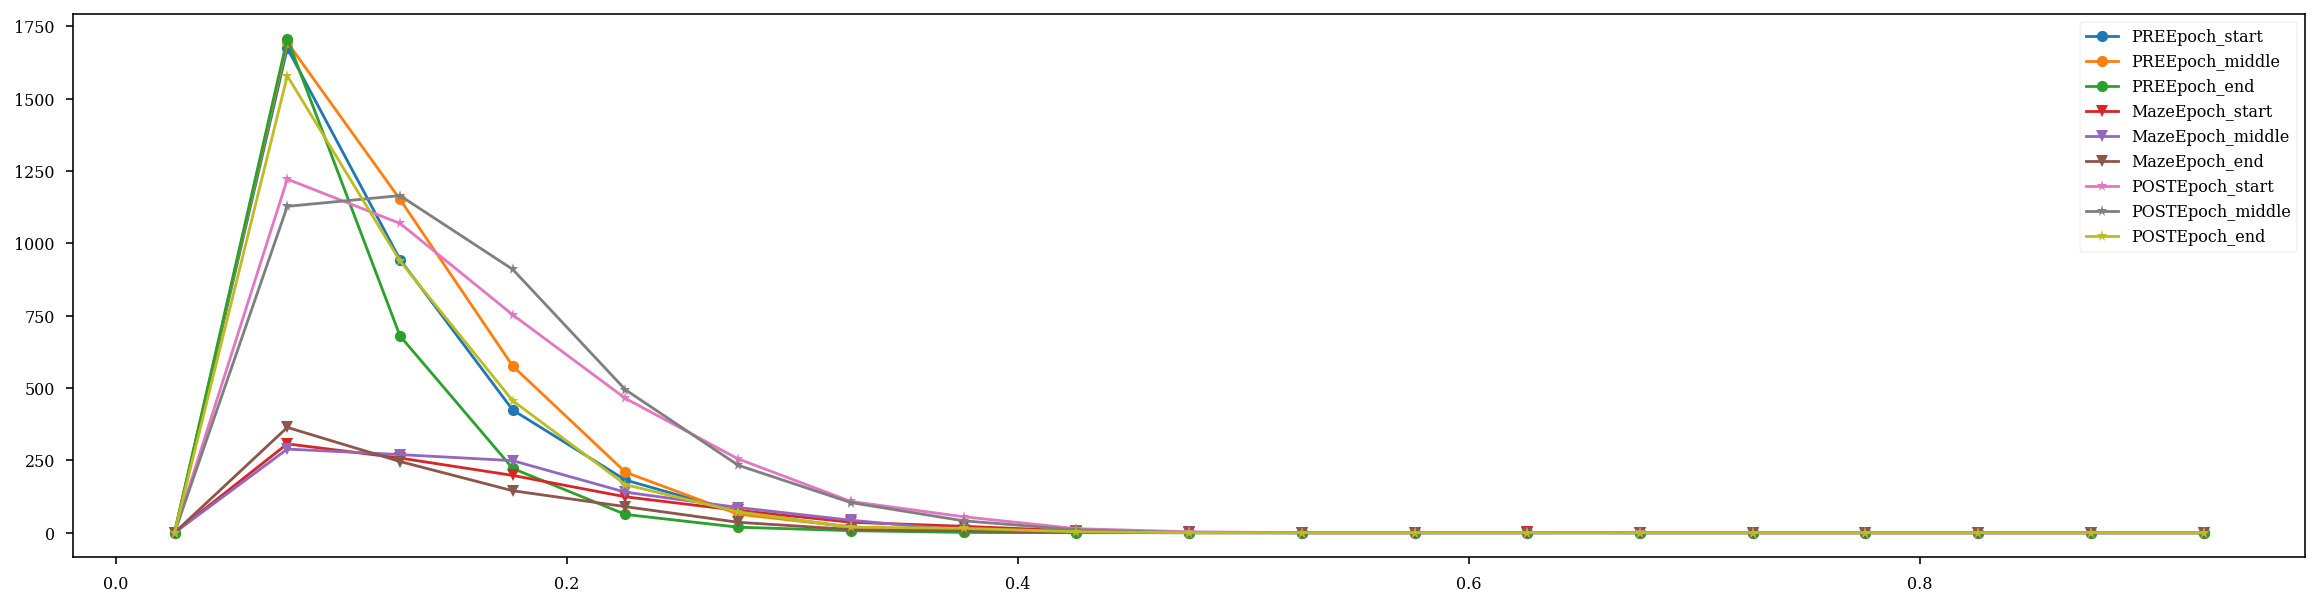

In [8]:
# for basepath in df_grosmark.basepath.unique():
basepath = df_grosmark.basepath.unique()[3]
_,data = loading.load_cell_metrics(basepath)

# bins = np.arange(0,.2,0.005)
bin_width = 0.05
bins = np.arange(0.001,1,bin_width)
bin_centers = bins[0:-1]+bin_width/2

plt.figure(figsize=(20,5))
linestyles = ["-","--",":"]
markers = ["o","v","*"]
for i,ep in enumerate(data["epochs"].itertuples()):
    temp_df = df_grosmark[(df_grosmark.peaks >= ep.startTime) &
                            (df_grosmark.peaks <= ep.stopTime) &
                            (df_grosmark.basepath==basepath)]

    binned,_ = np.histogram(temp_df['sup start'],bins = bins)
    plt.plot(bin_centers,binned,label=ep.name+'_start',marker=markers[i])

    binned,_ = np.histogram(temp_df['sup middle'],bins = bins)
    plt.plot(bin_centers,binned,label=ep.name+'_middle',marker=markers[i])

    binned,_ = np.histogram(temp_df['sup end'],bins = bins)
    plt.plot(bin_centers,binned,label=ep.name+'_end',marker=markers[i])
plt.legend()
# plt.xscale("log")

In [10]:
def make_df(temp_df):
    long_temp_df = pd.DataFrame()

    long_temp_df["prop"] = np.hstack([temp_df['deep start'],
                                    temp_df['deep middle'],
                                    temp_df['deep end'],
                                    temp_df['sup start'],
                                    temp_df['sup middle'],
                                    temp_df['sup end']])

    long_temp_df["duration"] = np.hstack([temp_df['duration']] * 6)

    long_temp_df['layer'] = (
                            ["deep"]*len(np.hstack([temp_df['deep start'],
                                        temp_df['deep middle'],
                                        temp_df['deep end']])) +
                            ["sup"]*len(np.hstack([temp_df['sup start'],
                                        temp_df['sup middle'],
                                        temp_df['sup end']]))
                            )
    n = len(temp_df['deep start'])
    long_temp_df['ripple segment'] = (
                                ["start"]*n +
                                ["middle"]*n +
                                ["end"]*n +
                                ["start"]*n +
                                ["middle"]*n +
                                ["end"]*n
                            )
    return long_temp_df

long_temp_df = pd.DataFrame()
for basepath in df_grosmark.basepath.unique():
    # basepath = df_grosmark.basepath.unique()[7]
    _,data = loading.load_cell_metrics(basepath)
    
    for i,ep in enumerate(data["epochs"].itertuples()):
        temp_df = df_grosmark[(df_grosmark.peaks >= ep.startTime) &
                                (df_grosmark.peaks <= ep.stopTime) &
                                (df_grosmark.basepath==basepath)]

        temp_df = make_df(temp_df) 
        temp_df["epoch"] = ep.name
        temp_df['basepath'] = basepath
        temp_df['basename'] = os.path.basename(basepath)

        long_temp_df = long_temp_df.append(temp_df,ignore_index=True)

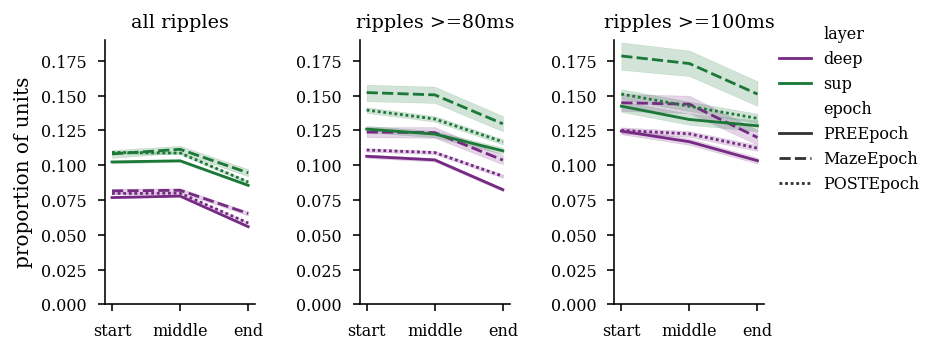

In [63]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=1, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.7)
axs = axs.ravel()

group_colors = {"deep": '#762a83',
                'sup': '#1b7837'} 

sns.set_palette(sns.color_palette(group_colors.values()))

idx = (long_temp_df.prop.values>0) 
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",style="epoch",
             data=long_temp_df[idx],
             hue_order=group_colors.keys(),
             ax=axs[0],legend=False)

idx = (long_temp_df.prop.values>0) & (long_temp_df.duration.values>=0.08) 
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",style="epoch",
             data=long_temp_df[idx],
             hue_order=group_colors.keys(),
             ax=axs[1],legend=False)

idx = (long_temp_df.prop.values>0) & (long_temp_df.duration.values>=0.1) 
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",style="epoch",
             data=long_temp_df[idx],
             hue_order=group_colors.keys(),
             ax=axs[2])

plt.legend(bbox_to_anchor=(1, 0.01, 0.5, 1.1),frameon=False)
ax = plt.gca()

for i in range(3):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].set_ylim(0,.19)
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")

axs[0].set_ylabel("ripple segments")
axs[0].set_ylabel("proportion of units")

axs[0].set_title("all ripples")
axs[1].set_title("ripples >=80ms")
axs[2].set_title("ripples >=100ms")

plt.savefig(os.path.join(fig_save_path,'swr_segment_pretaskpost_all.pdf'),dpi=300,bbox_inches='tight')


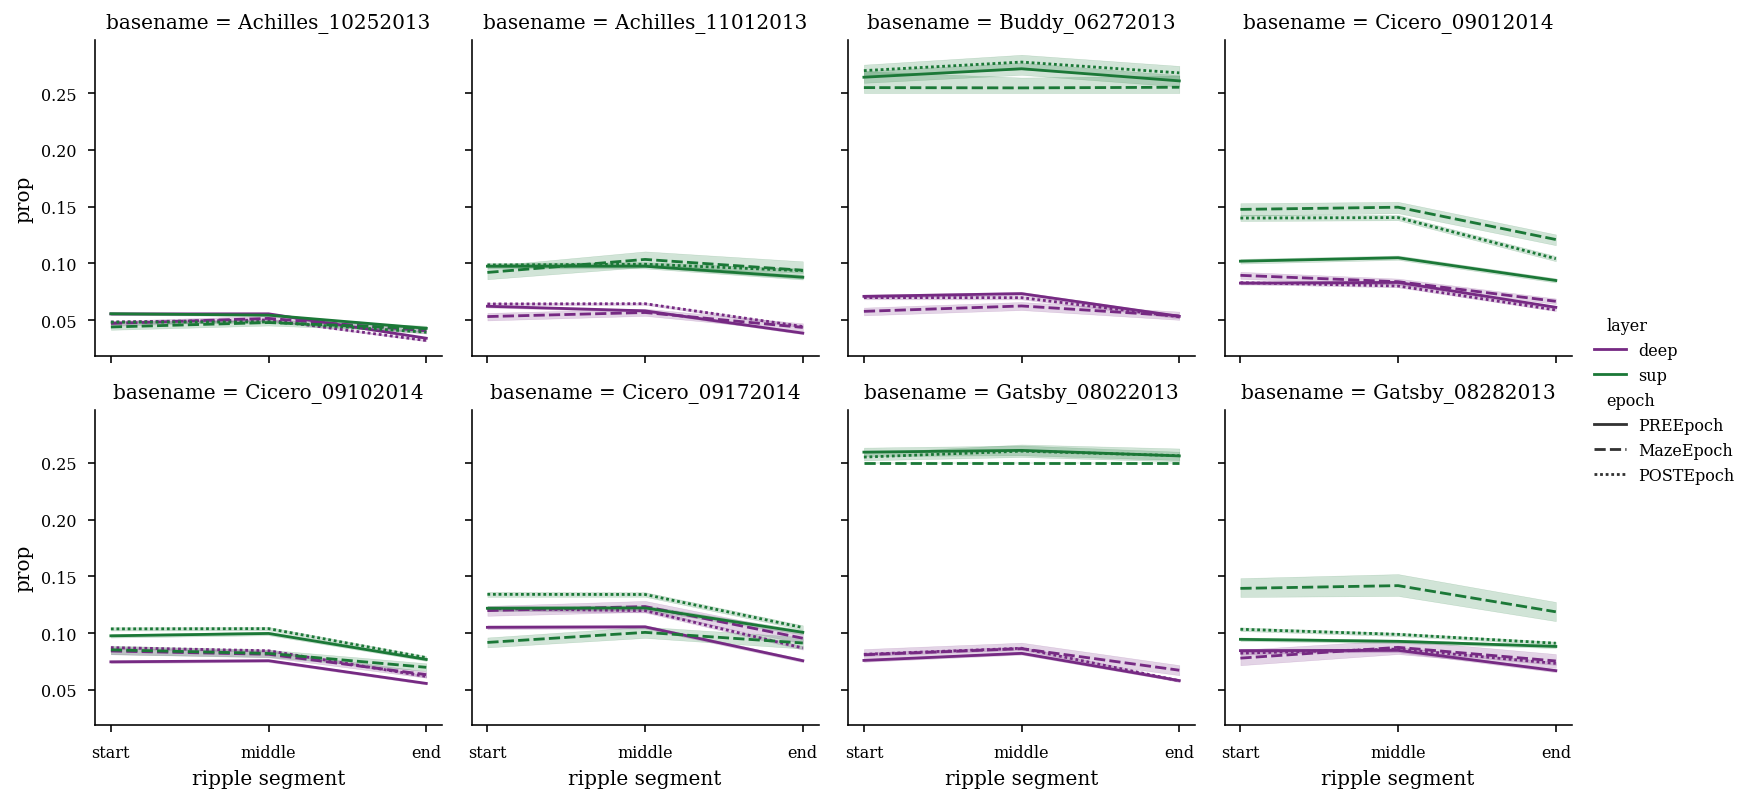

In [122]:
idx = (long_temp_df.prop.values>0) 

width,height = functions.set_size('thesis', fraction=1.5, subplots=(2, 4))
sns.relplot(
    data=long_temp_df[idx], x="ripple segment", y="prop",
    col="basename", hue="layer", style="epoch",
    kind="line",col_wrap=4,height=height
)
# plt.legend(bbox_to_anchor=(1, 0.01, 0.5, 1.1),frameon=False)

plt.savefig(os.path.join(fig_save_path,'swr_segment_pretaskpost_basepaths.pdf'),dpi=300,bbox_inches='tight')

# plt.ylim(0,0.3)

(0.0, 0.7)

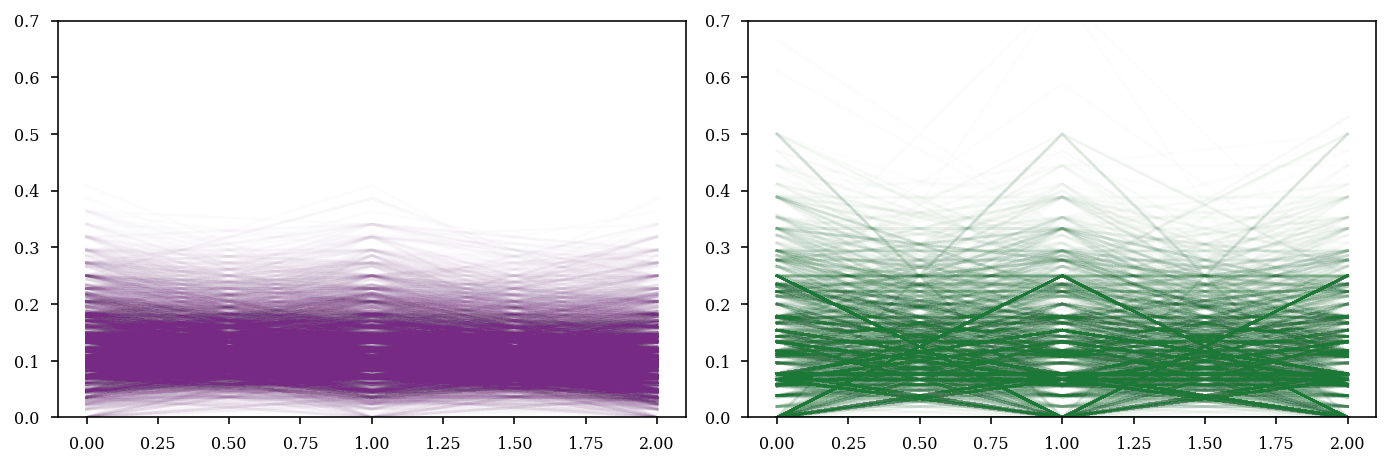

In [104]:
# long_temp_df[(long_temp_df['layer'] == "deep") & (long_temp_df['ripple segment'] == "start")]

df_grosmark.keys()
# x = np.random.rand(df_grosmark.shape[0])
# random_idx = x > .9

fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=2, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.1)
axs = axs.ravel()

idx = np.any(df_grosmark[['deep start', 'deep middle', 'deep end','sup start', 'sup middle','sup end']].values > 0,axis=1) & (df_grosmark.duration>=.1)
axs[0].plot(df_grosmark[['deep start', 'deep middle', 'deep end']][idx].values.T,alpha=.01,color="#762a83")

axs[1].plot(df_grosmark[['sup start', 'sup middle', 'sup end']][idx].values.T,alpha=.01,color="#1b7837")

axs[0].set_ylim(0,.7)
axs[1].set_ylim(0,.7)


<AxesSubplot:xlabel='ripple segment', ylabel='prop'>

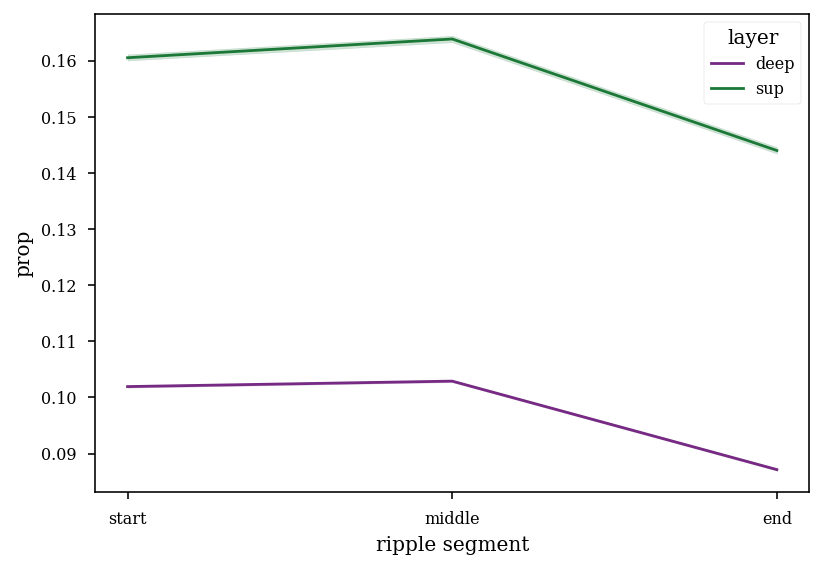

In [13]:
long_temp_df = pd.DataFrame()
# for basepath in results.basepath.unique():

temp_df = make_df(results) 
# temp_df["epoch"] = ep.name
# temp_df['basepath'] = basepath
# temp_df['basename'] = os.path.basename(basepath)

long_temp_df = long_temp_df.append(temp_df,ignore_index=True)

group_colors = {"deep": '#762a83',
                'sup': '#1b7837'} 

sns.set_palette(sns.color_palette(group_colors.values()))

idx = (long_temp_df.prop.values>0) 
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",
             data=long_temp_df[idx],
             hue_order=group_colors.keys())

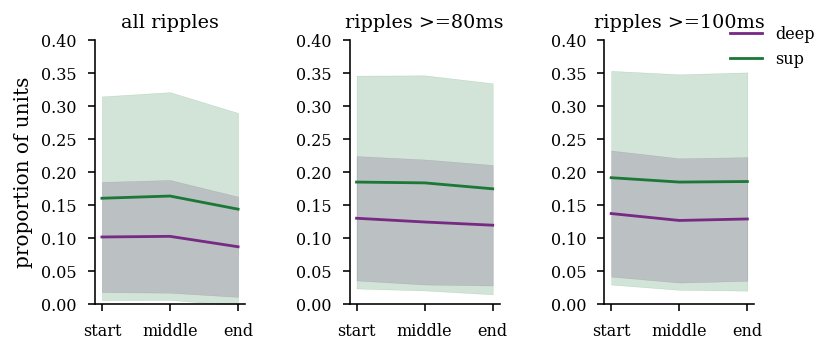

In [132]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=1, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.7)
axs = axs.ravel()

group_colors = {"deep": '#762a83',
                'sup': '#1b7837',} 

sns.set_palette(sns.color_palette(group_colors.values()))

idx = (long_temp_df.prop.values>0) 
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",
             data=long_temp_df[idx],
             hue_order=group_colors.keys(),
             ci="sd",
             ax=axs[0],legend=False)

idx = (long_temp_df.prop.values>0) & (long_temp_df.duration.values>=0.08) 
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",
             data=long_temp_df[idx],
             hue_order=group_colors.keys(),
             ci="sd",
             ax=axs[1],legend=False)

idx = (long_temp_df.prop.values>0) & (long_temp_df.duration.values>=0.1) 
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",
             data=long_temp_df[idx],
             hue_order=group_colors.keys(),
             ci="sd",
             ax=axs[2])

plt.legend(bbox_to_anchor=(1, 0.01, 0.5, 1.1),frameon=False)
ax = plt.gca()

for i in range(3):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].set_ylim(0,.4)
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")

axs[0].set_ylabel("ripple segments")
axs[0].set_ylabel("proportion of units")

axs[0].set_title("all ripples")
axs[1].set_title("ripples >=80ms")
axs[2].set_title("ripples >=100ms")

plt.savefig(os.path.join(fig_save_path,'swr_segment_all_data_sd.pdf'),dpi=300,bbox_inches='tight')


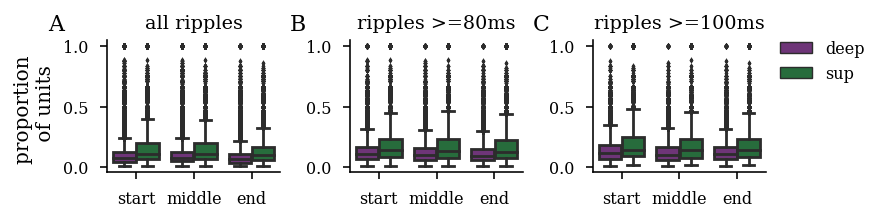

In [38]:

def plot_the_box(df,x,y,hue,group_colors,ax):
    sns.boxplot(x=x, y=y, data=df,fliersize=1,hue=hue,
                 ax=ax,hue_order=group_colors.keys())

    # sns.stripplot(x=x, y=y, data=df,
    #             size=2, color="k", linewidth=0,ax=ax,hue=hue,
    #             alpha=.5,dodge=True,hue_order=group_colors.keys())

fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=1, subplots=(1, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.4)
axs = axs.ravel()

idx = (long_temp_df.prop.values>0)
plot_the_box(long_temp_df[idx],"ripple segment","prop","layer",group_colors,axs[0])
# long_temp_df

idx = (long_temp_df.prop.values>0) & (long_temp_df.duration.values>=0.08) 
plot_the_box(long_temp_df[idx],"ripple segment","prop","layer",group_colors,axs[1])

idx = (long_temp_df.prop.values>0) & (long_temp_df.duration.values>=0.1) 
plot_the_box(long_temp_df[idx],"ripple segment","prop","layer",group_colors,axs[2])

axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend([],[], frameon=False)

axs[2].legend(bbox_to_anchor=(1.15, 0.01, 0.5, 1.1),frameon=False)

for i in range(3):
    # axs[i].set_ylim(-1.1,1.1)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    # axs[i].set_yscale("log")
    
axs[0].set_ylabel("ripple segments")
axs[0].set_ylabel("proportion \n of units")

axs[0].set_title("all ripples")
axs[1].set_title("ripples >=80ms")
axs[2].set_title("ripples >=100ms")

for i, label in enumerate(('A','B', 'C')):
    axs[i].text(-0.25, 1.2, label, transform=axs[i].transAxes,
      fontsize=11, fontweight='normal', va='top', ha='right')

          
plt.savefig(os.path.join(fig_save_path,'swr_segment_all_data_boxplots.pdf'),dpi=300,bbox_inches='tight')


In [260]:
def ToIntervals(x,index=[]):

    index_len = len(index)
    if index_len == 0:
        index = x

    index = list(index*1)

    if index[-1] == 1:
        index.append(0)

    din = np.diff(np.insert(index, 0,0))

    start = din == 1
    stop = din == -1

    intervals = np.vstack([np.where(start), np.where(stop)]).T

    if index_len > 0:
        intervals = x[intervals]
    return intervals

def get_restrict_index(ts,starts,stops):
    index = []
    for i in range(len(starts)):
        index.append((ts >= starts[i]) & (ts <= stops[i])) 
    return np.any(np.vstack(index),axis=0)

long_temp_df = pd.DataFrame()
states = ['WAKEstate','NREMstate']
for basepath in results.basepath.unique():
    data = loading.load_SleepState_states(basepath)

    for state in states:
        try:
            temp_df = results[get_restrict_index(results.peaks,data[state][:,0],data[state][:,1]) &
                                    (results.basepath==basepath)]
        except:
            continue
        temp_df = make_df(temp_df) 
        temp_df["state"] = state
        temp_df['basepath'] = basepath
        temp_df['basename'] = os.path.basename(basepath)

        long_temp_df = long_temp_df.append(temp_df,ignore_index=True)


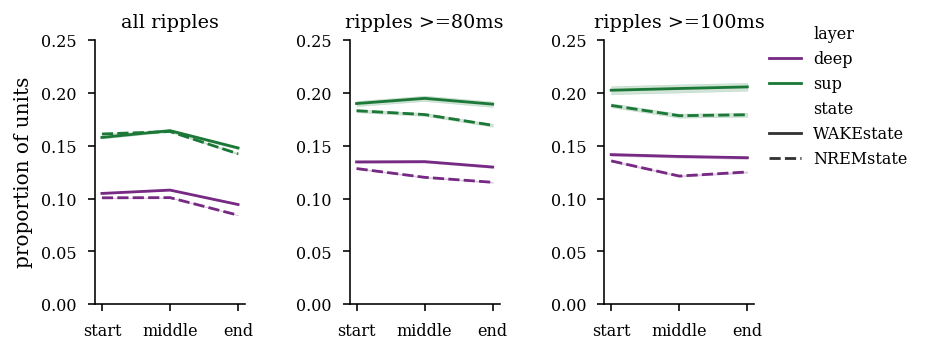

In [266]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=1, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.7)
axs = axs.ravel()

group_colors = {"deep": '#762a83',
                'sup': '#1b7837',} 

sns.set_palette(sns.color_palette(group_colors.values()))

idx = (long_temp_df.prop.values>0) 
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",style="state",
             data=long_temp_df[idx],
             hue_order=group_colors.keys(),
             ax=axs[0],legend=False)

idx = (long_temp_df.prop.values>0) & (long_temp_df.duration.values>=0.08) 
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",style="state",
             data=long_temp_df[idx],
             hue_order=group_colors.keys(),
             ax=axs[1],legend=False)

idx = (long_temp_df.prop.values>0) & (long_temp_df.duration.values>=0.1) 
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",style="state",
             data=long_temp_df[idx],
             hue_order=group_colors.keys(),
             ax=axs[2])

plt.legend(bbox_to_anchor=(1, 0.01, 0.5, 1.1),frameon=False)
ax = plt.gca()

for i in range(3):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].set_ylim(0,.25)
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")

axs[0].set_ylabel("ripple segments")
axs[0].set_ylabel("proportion of units")

axs[0].set_title("all ripples")
axs[1].set_title("ripples >=80ms")
axs[2].set_title("ripples >=100ms")

plt.savefig(os.path.join(fig_save_path,'swr_segment_wake_nrem.pdf'),dpi=300,bbox_inches='tight')

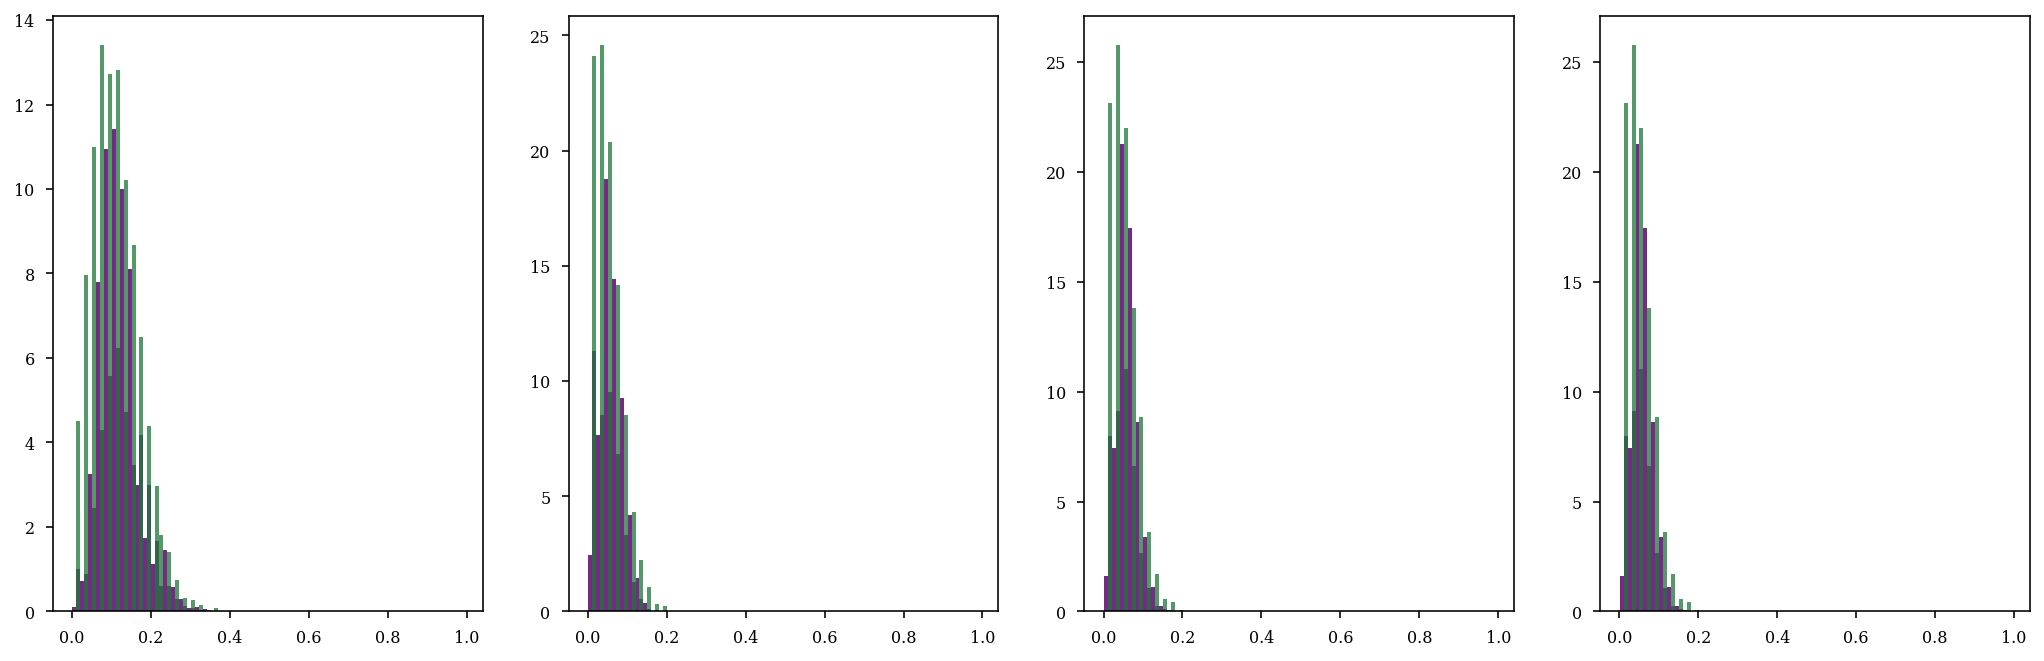

In [85]:
fig, axs = plt.subplots(1,4,figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.2)
axs = axs.ravel()

bins = np.arange(0.001,1,0.01)

axs[0].hist(temp_df['deep whole'],bins = bins,density=True,color='#762a83')
axs[0].hist(temp_df['sup whole'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[1].hist(temp_df['deep start'],bins = bins,density=True,color='#762a83')
axs[1].hist(temp_df['sup start'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[2].hist(temp_df['deep middle'],bins = bins,density=True,color='#762a83')
axs[2].hist(temp_df['sup middle'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[3].hist(temp_df['deep end'],bins = bins,density=True,color='#762a83')
axs[3].hist(temp_df['sup end'],bins = bins,density=True,color='#1b7837',alpha=.75)

plt.show()

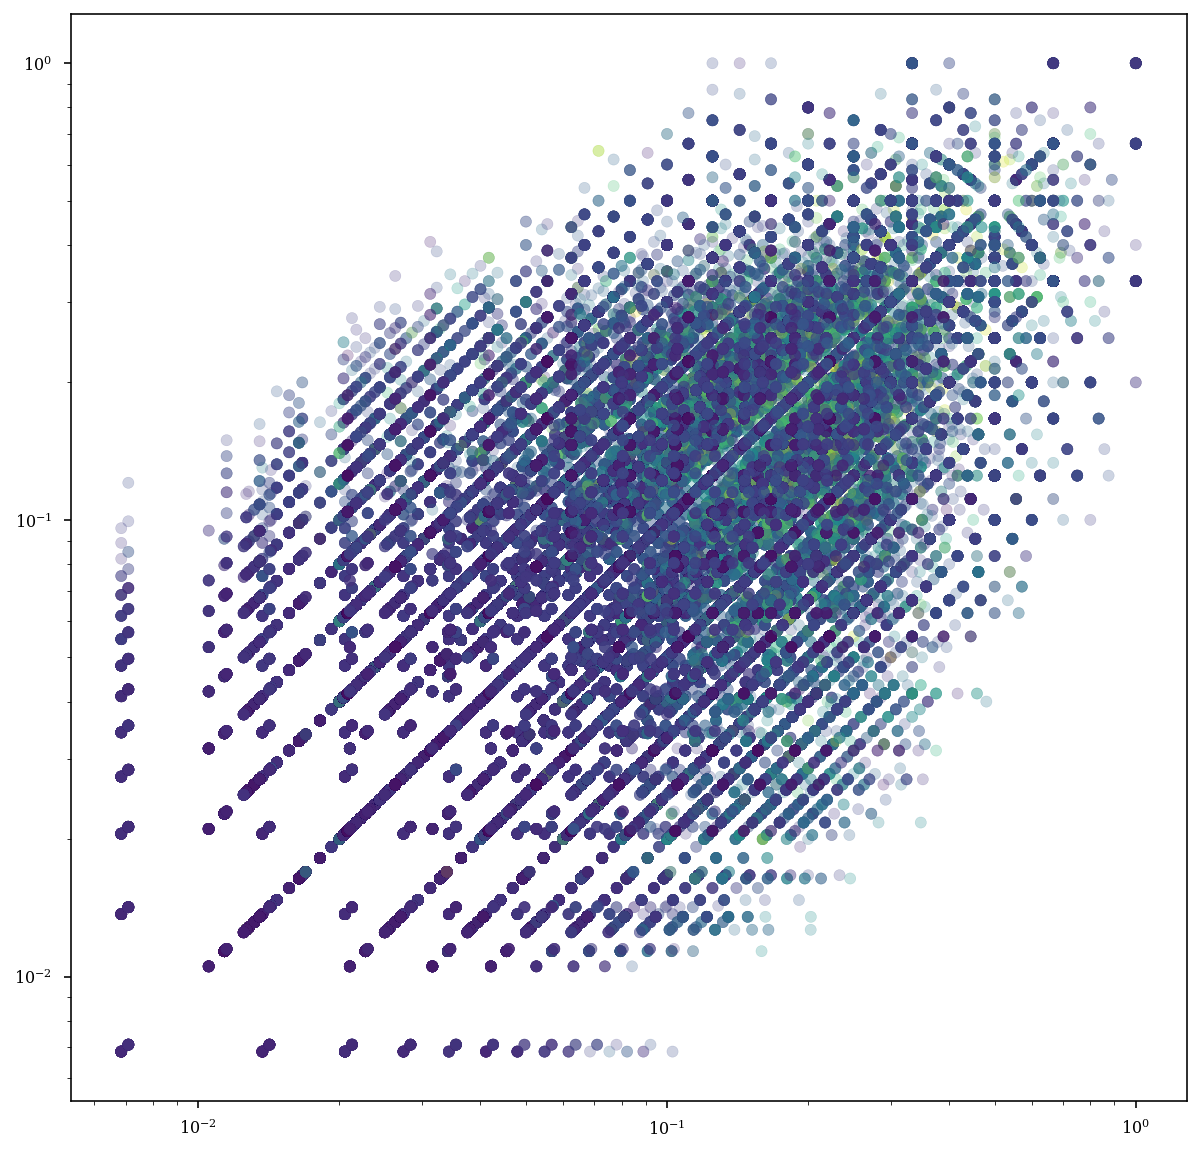

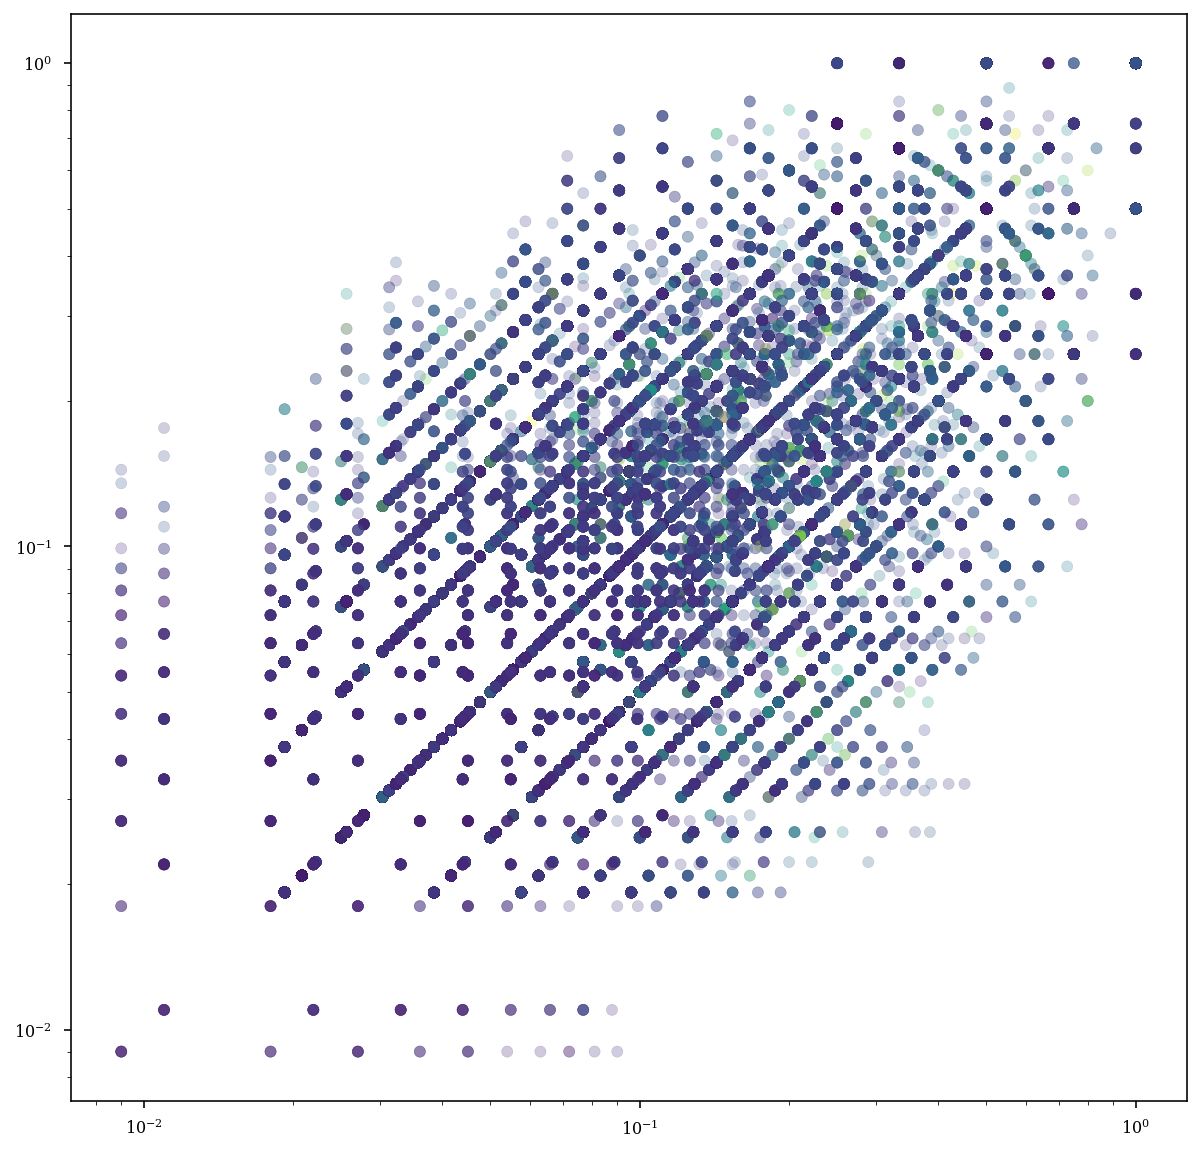

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(results['deep start'],results['deep end'],alpha=.25,c=results.duration)
plt.xscale("log")
plt.yscale("log")

plt.figure(figsize=(10,10))
plt.scatter(results['sup start'],results['sup end'],alpha=.25,c=results.duration)
plt.xscale("log")
plt.yscale("log")

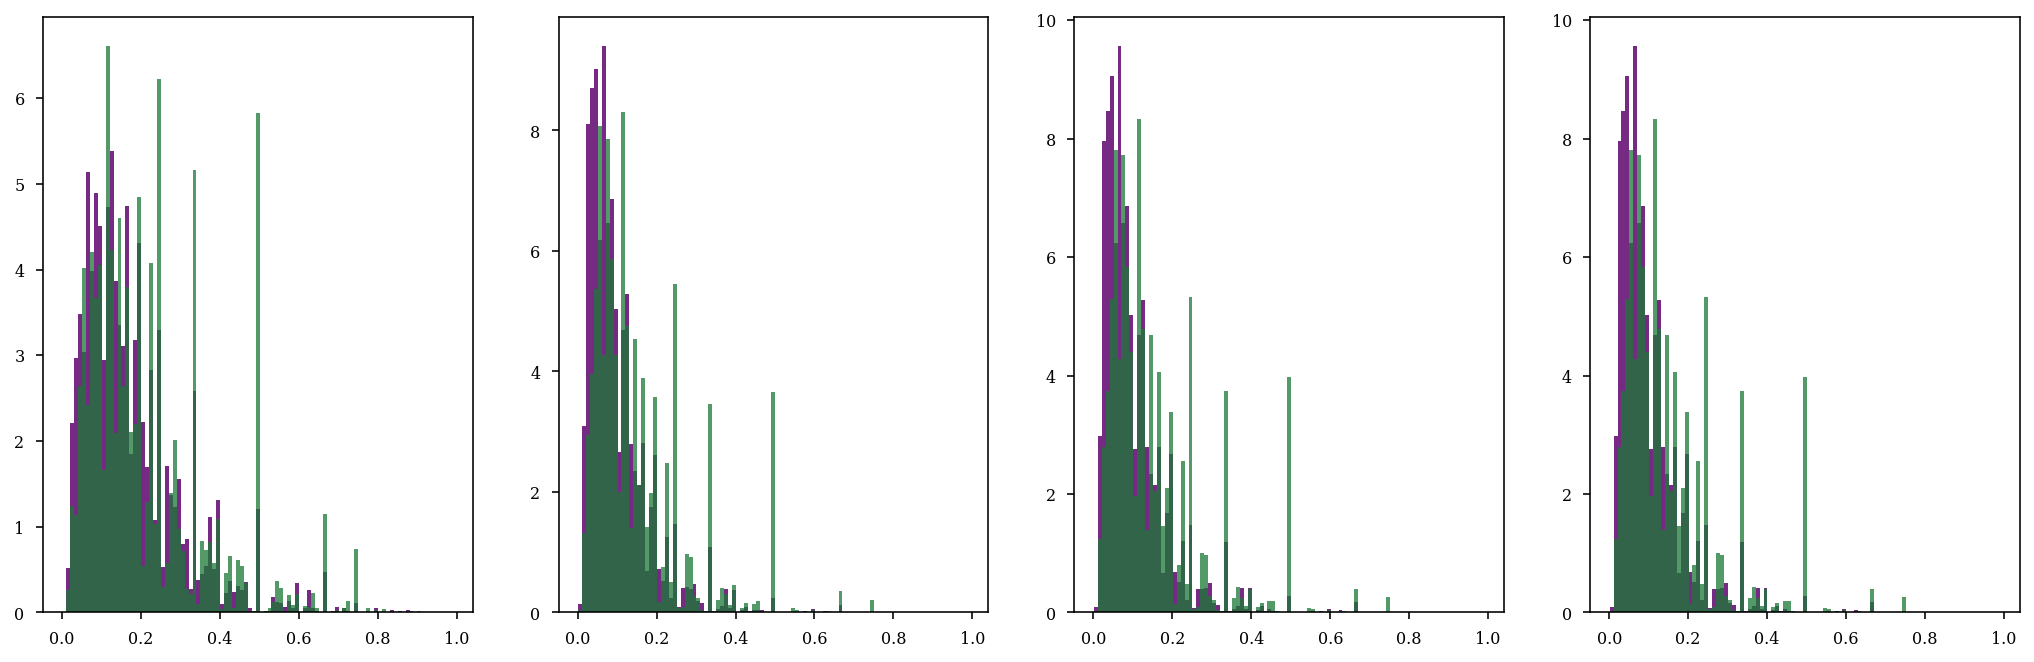

In [66]:
# plt.figure(figsize=(10,10))
bins = np.arange(0.001,1,0.01)
# plt.hist(results['sup start'],bins = bins)
# plt.hist(results['sup middle'],bins = bins,alpha=.5)
# plt.hist(results['sup end'],bins = bins,alpha=.25)

# plt.show()
# plt.scatter(results['deep whole'],results['sup whole'],alpha=.25)

fig, axs = plt.subplots(1,4,figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.2)
axs = axs.ravel()

axs[0].hist(results['deep whole'],bins = bins,density=True,color='#762a83')
axs[0].hist(results['sup whole'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[1].hist(results['deep start'],bins = bins,density=True,color='#762a83')
axs[1].hist(results['sup start'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[2].hist(results['deep middle'],bins = bins,density=True,color='#762a83')
axs[2].hist(results['sup middle'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[3].hist(results['deep end'],bins = bins,density=True,color='#762a83')
axs[3].hist(results['sup end'],bins = bins,density=True,color='#1b7837',alpha=.75)

plt.show()



# Testing and examples below

   name  startTime  stopTime
0  task        0.0    6022.4
1  post     6022.4   15169.1


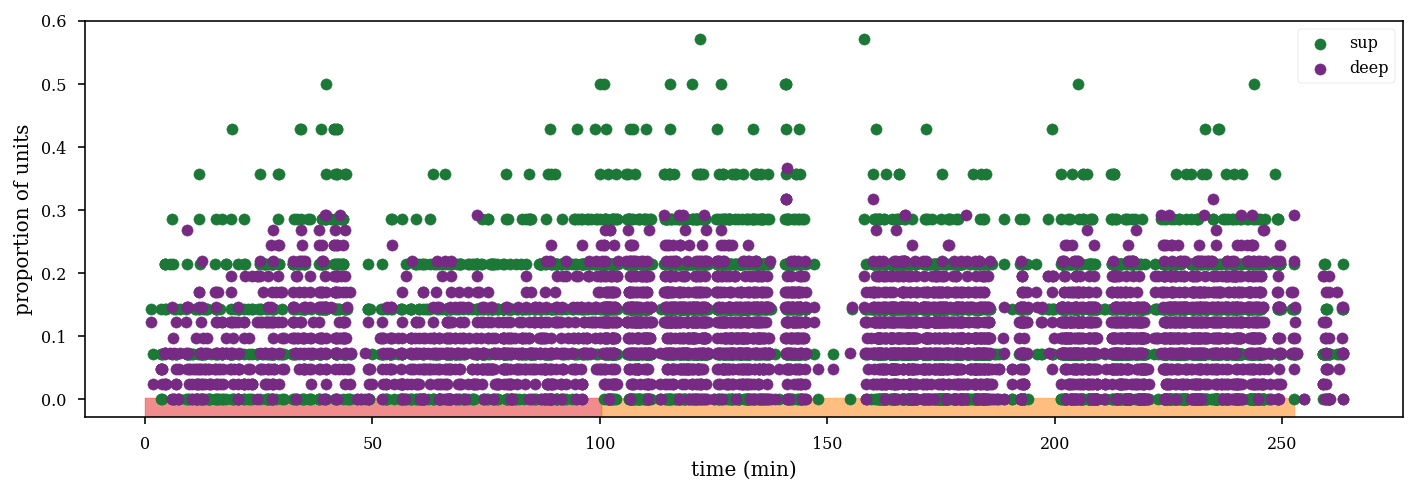

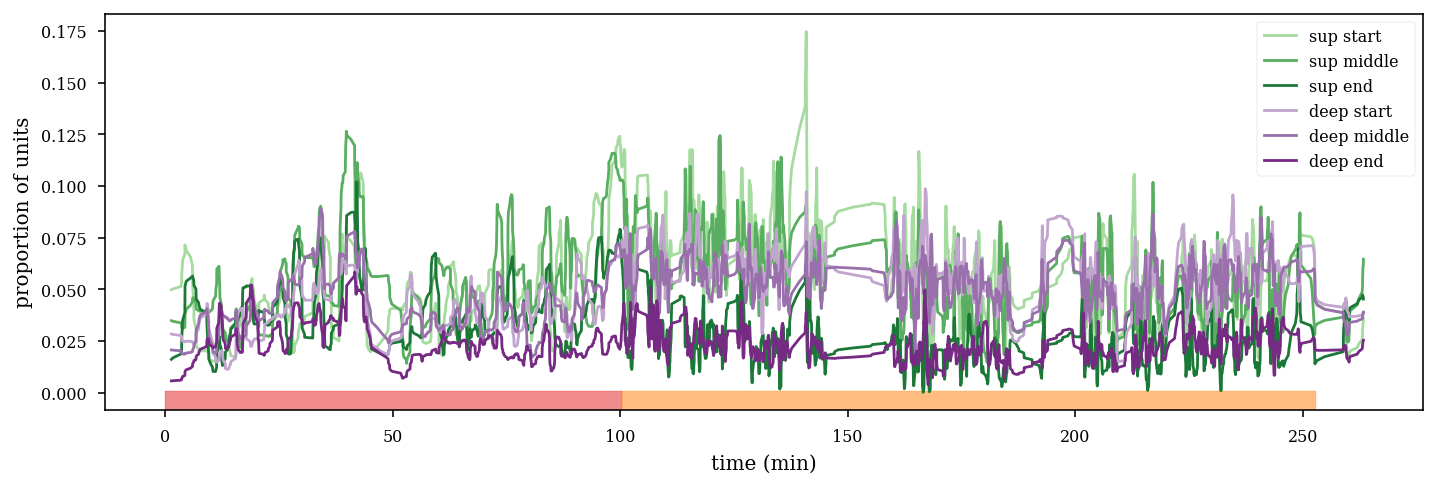

In [163]:
# plt.figure(figsize=(20,4))
# plt.imshow(n_deep,aspect="auto",interpolation="nearest",vmax=.3,vmin=0)
# plt.figure(figsize=(20,4))
# plt.imshow(n_sup,aspect="auto",interpolation="nearest",vmax=.3,vmin=0)
cmap = matplotlib.cm.get_cmap('Set1',data["epochs"].shape[0]+1)

plt.figure(figsize=functions.set_size('thesis', fraction=2, subplots=(1, 2)), edgecolor='k')
plt.scatter(ripples.peaks/60,n_sup_whole_rip[0,:],color='#1b7837',label="sup")
plt.scatter(ripples.peaks/60,n_deep_whole_rip[0,:],color='#762a83',label="deep")
plt.xlabel('time (min)')
plt.ylabel('proportion of units')

for i,epochs in enumerate(data["epochs"].itertuples()):
    plt.axvspan(epochs.startTime/60, epochs.stopTime/60,
                ymin=-.1,ymax=.05, alpha=0.5, color=cmap(i), zorder=-1000)
plt.legend()

plt.figure(figsize=functions.set_size('thesis', fraction=2, subplots=(1, 2)), edgecolor='k')

plt.plot(ripples.peaks/60,gaussian_filter1d(n_sup[0,:], 5),color='#a6dba0',label="sup start")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_sup[1,:], 5),color='#5aae61',label="sup middle")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_sup[2,:], 5),color='#1b7837',label="sup end")

plt.plot(ripples.peaks/60,gaussian_filter1d(n_deep[0,:], 5),color='#c2a5cf',label="deep start")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_deep[1,:], 5),color='#9970ab',label="deep middle")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_deep[2,:], 5),color='#762a83',label="deep end")

for i,epochs in enumerate(data["epochs"].itertuples()):
    plt.axvspan(epochs.startTime/60, epochs.stopTime/60,
                ymin=-.1,ymax=.05, alpha=0.5, color=cmap(i), zorder=-1000)
    # plt.axvline(epochs.startTime/60,color="k",zorder=-1000)
plt.xlabel('time (min)')
plt.ylabel('proportion of units')

plt.legend()
fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'
print(data["epochs"])
plt.savefig(os.path.join(fig_save_path,'ripple_segment_participation_example.pdf'),dpi=300,bbox_inches='tight')
# plt.savefig(os.path.join(fig_save_path,'ripple_segment_participation_example.png'),dpi=300,bbox_inches='tight')


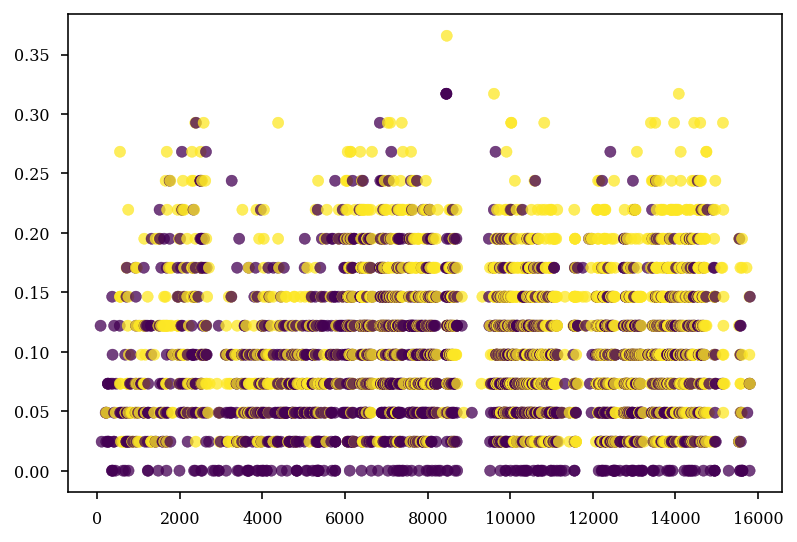

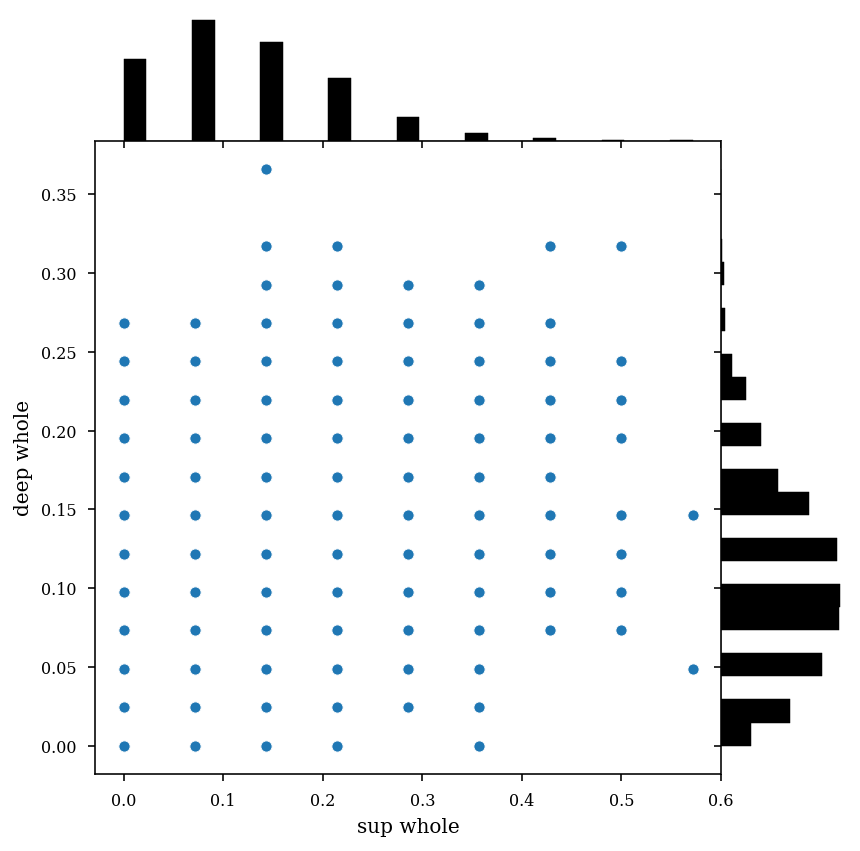

In [145]:
plt.scatter(ripples.peaks,n_deep_whole_rip[0,:],c=deep_dom,alpha=.75)
plt.show()

# plt.scatter(ripples.peaks,n_sup_whole_rip[0,:],c=ripples.duration,alpha=.75)
# plt.show()

g = sns.JointGrid(data=session_df, x="sup whole", y="deep whole", space=0)
g.plot_joint(sns.scatterplot,cmap="rocket")
g.plot_marginals(sns.histplot, color="k", alpha=1, bins=25)

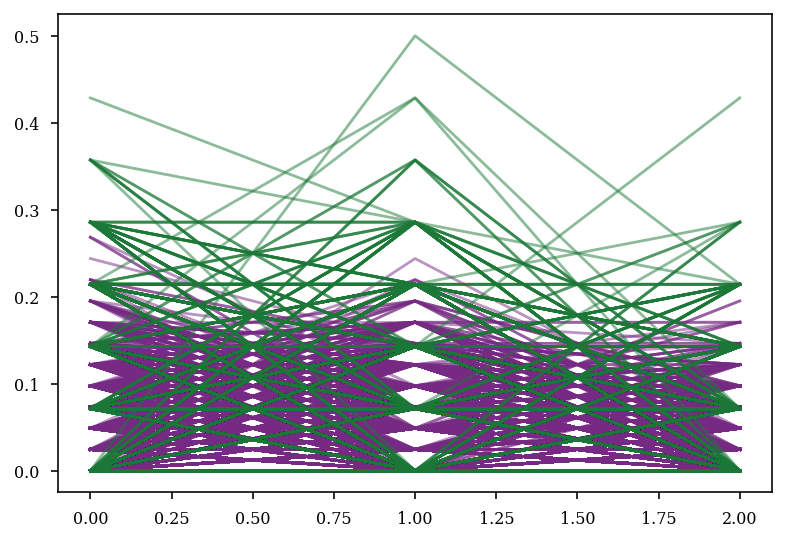

In [162]:
plt.plot(n_deep,color='#762a83',alpha=.5)
plt.plot(n_sup,color='#1b7837',alpha=.5)

plt.show()

In [165]:
sum(cell_metrics.deepSuperficial == "Superficial") / cell_metrics.shape[0]
sum(cell_metrics.deepSuperficial == "Deep") / cell_metrics.shape[0]


0.7454545454545455

In [169]:
n_deep_whole_rip[0,:]

array([0.12195122, 0.02439024, 0.04878049, ..., 0.07317073, 0.07317073,
       0.14634146])

In [182]:
print(n_deep_whole_rip[0,:])
n_deep_whole_rip[0,:] / sum(cell_metrics.deepSuperficial == "Deep")

[0.12195122 0.02439024 0.04878049 ... 0.07317073 0.07317073 0.14634146]


array([0.00297442, 0.00059488, 0.00118977, ..., 0.00178465, 0.00178465,
       0.0035693 ])

In [181]:
print(n_sup_whole_rip[0,:])
n_sup_whole_rip[0,:] / sum(cell_metrics.deepSuperficial == "Superficial")

[0.14285714 0.07142857 0.14285714 ... 0.14285714 0.07142857 0.21428571]


array([0.01020408, 0.00510204, 0.01020408, ..., 0.01020408, 0.00510204,
       0.01530612])

<AxesSubplot:>

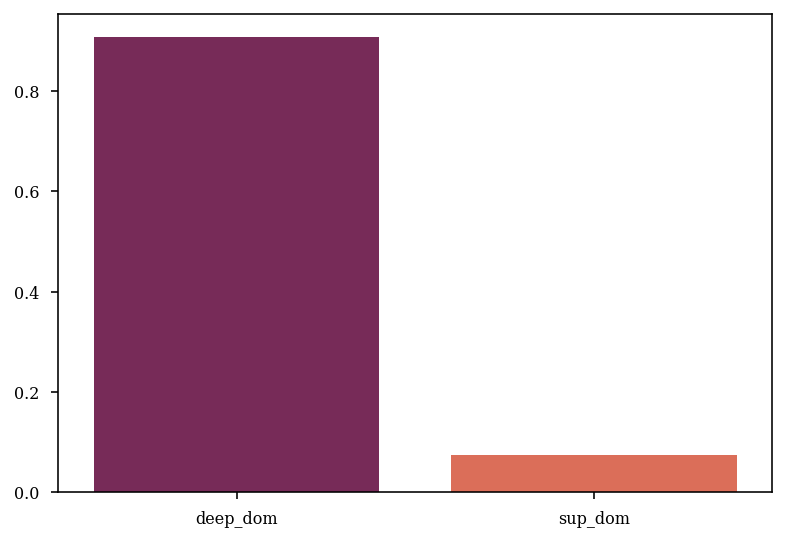

In [190]:
deep_dom = n_deep_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Deep")/cell_metrics.shape[0]) > n_sup_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Superficial")/cell_metrics.shape[0])
sup_dom = n_deep_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Deep")/cell_metrics.shape[0]) < n_sup_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Superficial")/cell_metrics.shape[0])

sns.barplot(x=['deep_dom','sup_dom'], y=[deep_dom.sum()/len(deep_dom),sup_dom.sum()/len(deep_dom)], palette="rocket")

In [156]:
deep_dom = n_deep_whole_rip[0,:] > n_sup_whole_rip[0,:]
sup_dom = n_deep_whole_rip[0,:] < n_sup_whole_rip[0,:]

equal_dom = n_deep_whole_rip[0,:] == n_sup_whole_rip[0,:]

np.where(sup_dom)[0][0:10]
# np.where(deep_dom)[0]


array([ 0,  1,  2,  3,  5,  6,  8,  9, 10, 11], dtype=int64)

In [140]:
session_df = pd.DataFrame()
session_df['duration'] = ripples.duration
session_df['peaks'] = ripples.peaks

session_df['deep whole'] = n_deep_whole_rip[0,:]
session_df['sup whole'] = n_sup_whole_rip[0,:]

session_df['deep start'] = n_deep[0,:]
session_df['deep middle'] = n_deep[1,:]
session_df['deep end'] = n_deep[1,:]
session_df['sup start'] = n_sup[0,:]
session_df['sup middle'] = n_sup[1,:]
session_df['sup end'] = n_sup[1,:]

# sns.histplot(data=session_df,stat="density",cumulative=True,element="step", fill=False)
# sns.histplot(data=session_df, element="step", fill=False,stat="density",common_bins=False,kde=True)


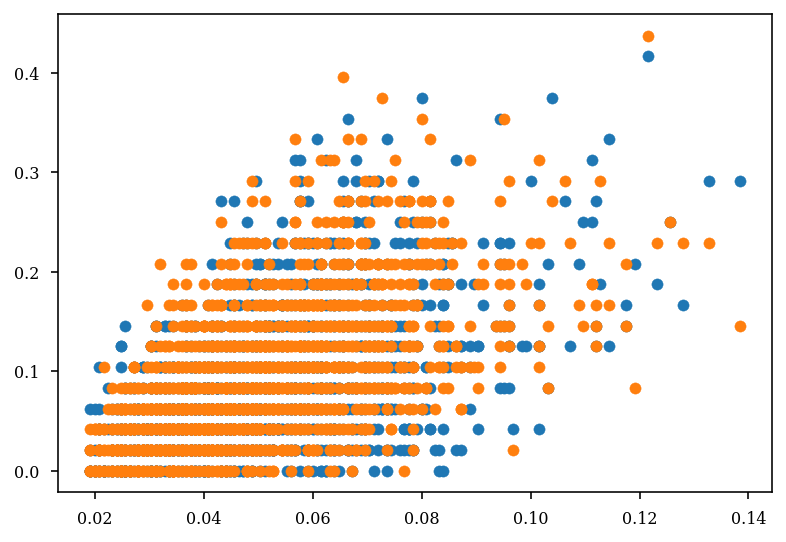

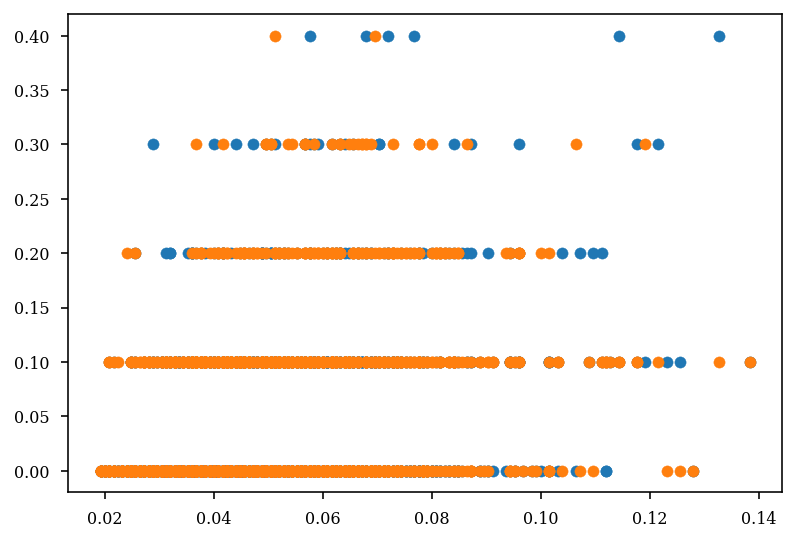

In [90]:
plt.scatter(ripples.duration,session_df['deep start'])
# plt.scatter(ripples.duration,session_df['deep middle'])
# plt.scatter(ripples.duration,session_df['deep end'])

plt.figure()
plt.scatter(ripples.duration,session_df['sup start'])
plt.scatter(ripples.duration,session_df['sup middle'])
# plt.scatter(ripples.duration,session_df['sup end'])

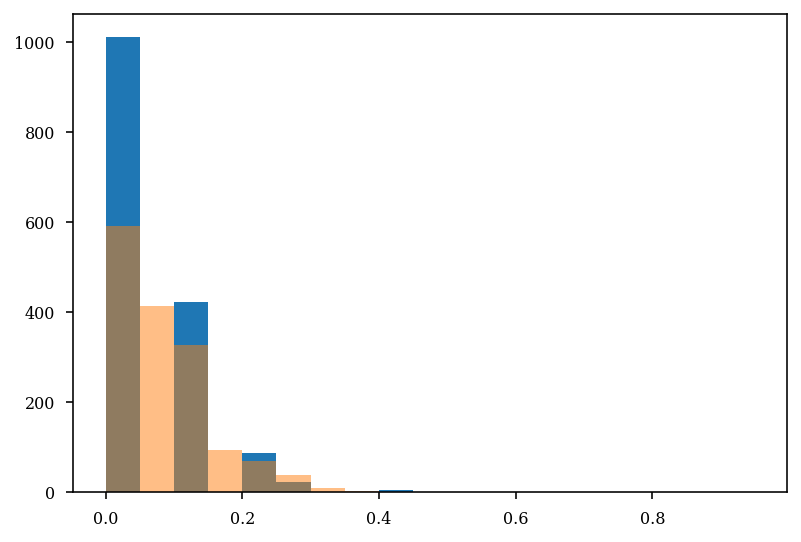

In [55]:
# plt.scatter(n_deep[2,:],n_sup[2,:])
bins = np.arange(0,1,.05)
plt.hist(n_sup[0,:],bins=bins)
plt.hist(n_deep[0,:],bins=bins,alpha=.5)

plt.show()

In [46]:
ts_epoch = []
for rip_i in range(ripple_epochs.n_intervals):
    ts = np.linspace(ripple_epochs[rip_i].starts,ripple_epochs[rip_i].stops,4)
    ts_epoch.append([ts[0],ts[1]])
    ts_epoch.append([ts[1],ts[2]])
    ts_epoch.append([ts[2],ts[3]])

ripple_seg_epochs = nel.EpochArray(np.hstack(ts_epoch).T)
st_rip_seg = st[ripple_seg_epochs]

# n_deep = []
# n_sup = []

def main_loop(rip_i,st_rip_seg,cell_metrics):
    active = [unit.shape[0]>0 for unit in st_rip_seg[rip_i].data]

    return sum(cell_metrics.deepSuperficial[active] == "Deep"), sum(cell_metrics.deepSuperficial[active] == "Superficial")

# for i in tqdm(range(st_rip_seg.n_intervals)):
#     active = [unit.shape[0]>0 for unit in st_rip_seg[i].data]
#     n_deep.append(sum(cell_metrics.deepSuperficial[active] == "Deep"))
#     n_sup.append(sum(cell_metrics.deepSuperficial[active] == "Superficial"))


num_cores = multiprocessing.cpu_count()  
results = Parallel(n_jobs=num_cores)(delayed(main_loop)(rip_i,st_rip_seg,cell_metrics) for rip_i in tqdm(range(st_rip_seg.n_intervals)))    


0it [00:00, ?it/s]


TypeError: 'PrettyInt' object is not iterable

In [55]:
def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    # 1 for at least 1 spike, 0 otherwise
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events > 0)*1 
        # unit_mat[:,i] = event.n_events/ripple_epochs[i].length
    return unit_mat

unit_mat = get_participation(st_rip_seg,ripple_seg_epochs)


SystemError: <built-in method __deepcopy__ of numpy.ndarray object at 0x000001E1FC8DEF30> returned a result with an error set

100%|██████████| 31341/31341 [15:18<00:00, 34.13it/s]


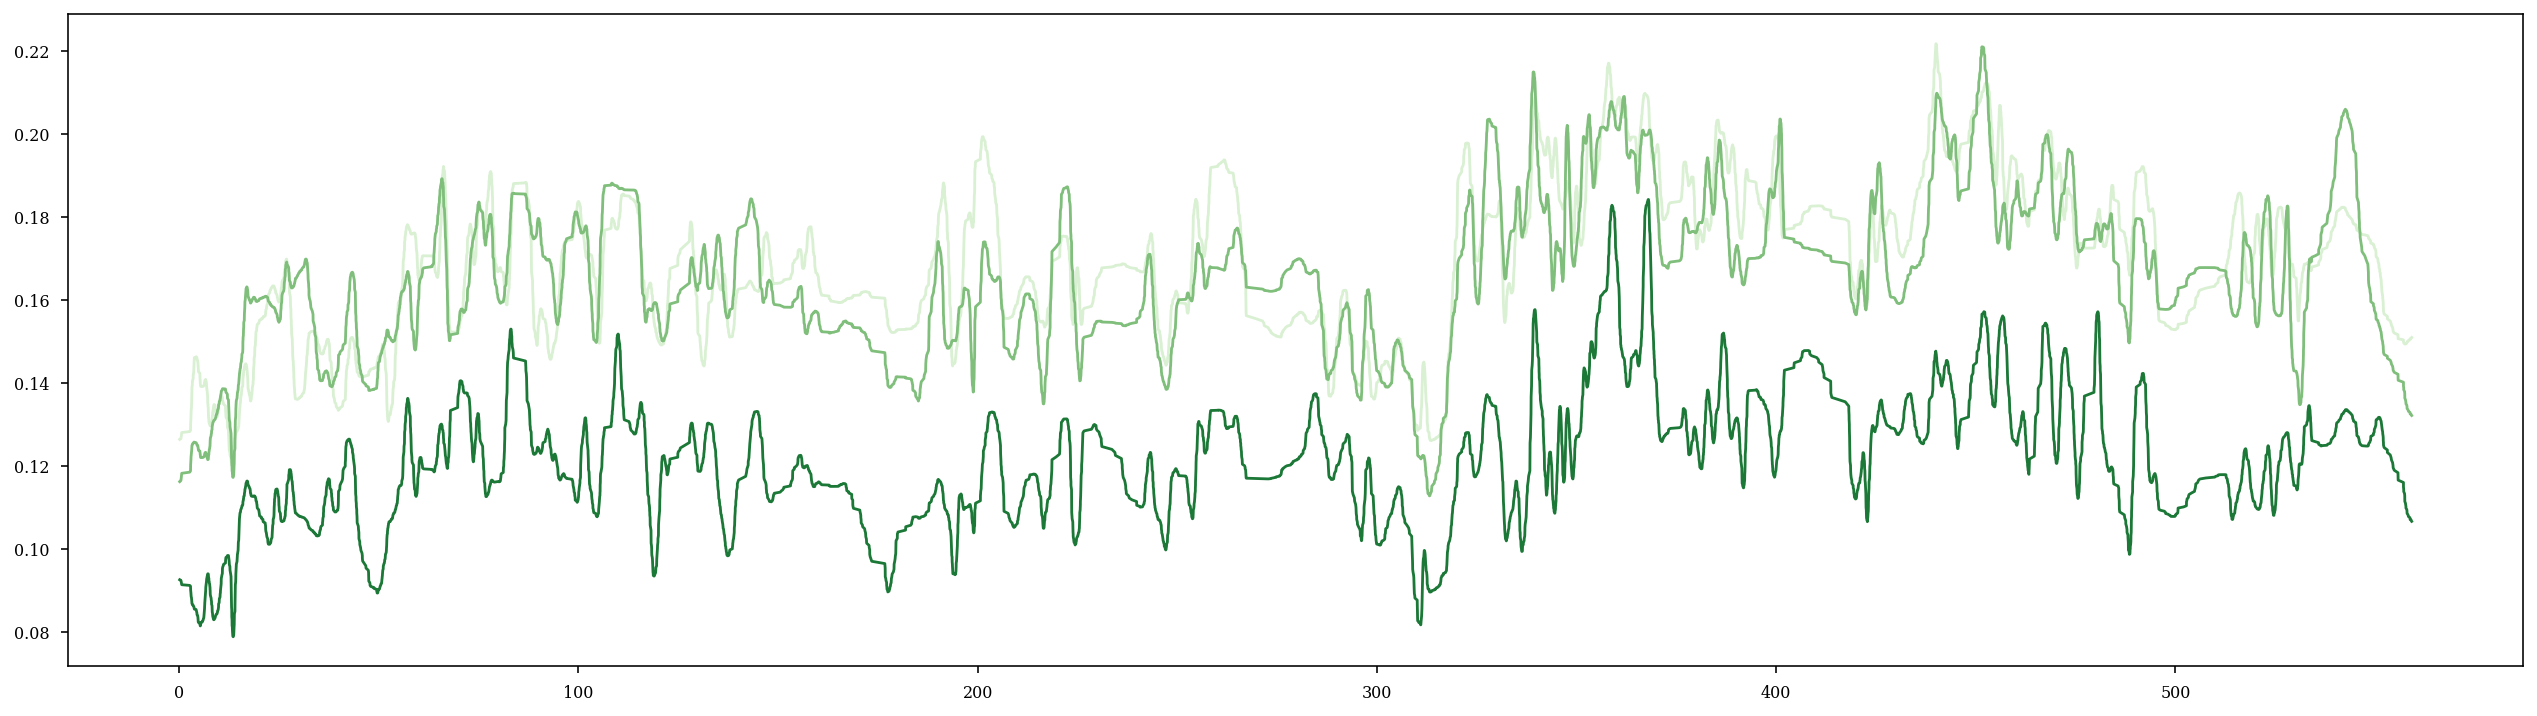

In [43]:
x = np.array(n_sup)
x = x.reshape(int(x.shape[0]/3),3)
x = x/sum(cell_metrics.deepSuperficial== "Superficial")
# plt.plot(x[:,1])

plt.figure(figsize=(22,6))
plt.plot(ripples.peaks/60,gaussian_filter1d(x[:,0], 20),color='#d9f0d3',label="sup start")
plt.plot(ripples.peaks/60,gaussian_filter1d(x[:,1], 20),color='#7fbf7b',label="sup middle")
plt.plot(ripples.peaks/60,gaussian_filter1d(x[:,2], 20),color='#1b7837',label="sup end")
plt.show()


In [168]:
import warnings
warnings.filterwarnings("ignore")
# parallel processing
import multiprocessing
from joblib import Parallel, delayed

def main_loop(rip_i,ripple_epochs,st_rip,cell_metrics,n_deep,n_sup,n_deep_whole_rip,n_sup_whole_rip):

    active = [unit.shape[0]>0 for unit in st_rip[rip_i].data]
    n_deep_whole_rip.append(sum(cell_metrics.deepSuperficial[active] == "Deep"))
    n_sup_whole_rip.append(sum(cell_metrics.deepSuperficial[active] == "Superficial"))

    ts = np.linspace(ripple_epochs[rip_i].starts,ripple_epochs[rip_i].stops,4)
    within_ripple_epochs = nel.EpochArray(np.array([[ts[0],ts[1]],[ts[1],ts[2]],[ts[2],ts[3]]]))
    for rip_inter in range(3):
        active = [unit.shape[0]>0 for unit in st_rip[rip_i][within_ripple_epochs][rip_inter].data]
        n_deep.append(sum(cell_metrics.deepSuperficial[active] == "Deep"))
        n_sup.append(sum(cell_metrics.deepSuperficial[active] == "Superficial"))

    return n_deep,n_sup,n_deep_whole_rip,n_sup_whole_rip

n_deep = []
n_sup = []
n_deep_whole_rip = []
n_sup_whole_rip = []

parallel = 1

# if parallel==1:
num_cores = multiprocessing.cpu_count()  
results = Parallel(n_jobs=num_cores)(delayed(main_loop)(rip_i,
                                                            ripple_epochs,
                                                            st_rip,
                                                            cell_metrics,
                                                            n_deep,
                                                            n_sup,
                                                            n_deep_whole_rip,
                                                            n_sup_whole_rip) for rip_i in tqdm(range(20)))
n_deep,n_sup,n_deep_whole_rip,n_sup_whole_rip
# else:
#     for session in sessions:
#         sys.stdout.write('\rcurrent cell: %s' %(session))
#         sys.stdout.flush()
#         print(session)
#         main_loop(session,data_path,save_path)

# normalize by n units
# n_deep = n_deep/sum(cell_metrics.deepSuperficial == "Deep")
# n_sup = n_sup/sum(cell_metrics.deepSuperficial == "Superficial")
# n_deep_whole_rip = n_deep_whole_rip/sum(cell_metrics.deepSuperficial == "Deep")
# n_sup_whole_rip = n_sup_whole_rip/sum(cell_metrics.deepSuperficial == "Superficial")


100%|██████████| 20/20 [00:00<00:00, 6686.81it/s]


([], [], [], [])

In [186]:
n_deep = np.zeros([3,ripple_epochs.n_intervals])
n_sup = np.zeros_like(n_deep)
n_deep_whole_rip = np.zeros([1,ripple_epochs.n_intervals])
n_sup_whole_rip = np.zeros_like(n_deep_whole_rip)

for i,rip_1 in enumerate(results):
    n_deep[:,i],n_sup[:,i],n_deep_whole_rip[0,i],n_sup_whole_rip[0,i] = rip_1

ValueError: setting an array element with a sequence.

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-

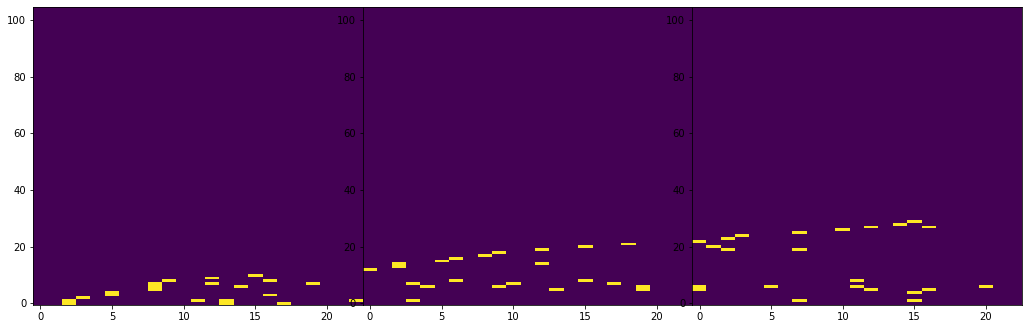

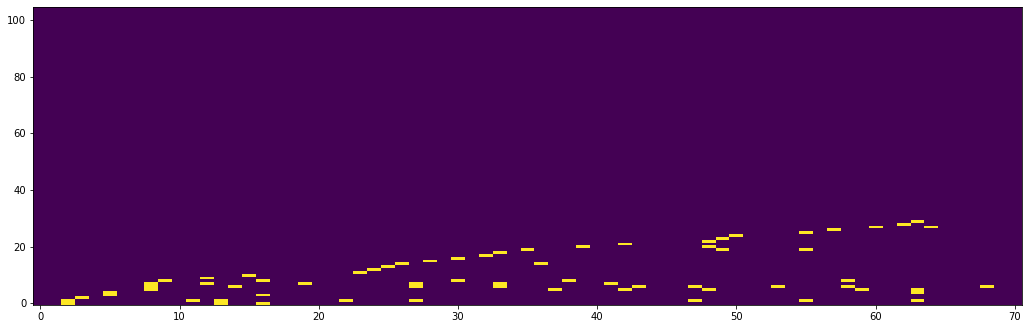

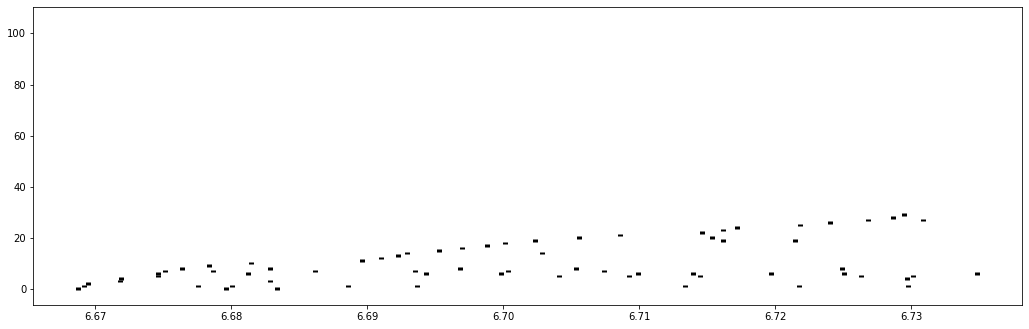

In [107]:
fr_order = np.array(st_rip[0].get_event_firing_order()) - 1

fig, axs = plt.subplots(1,3,figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0)
axs = axs.ravel()

binnedst = st_rip[0][within_ripple_epochs][0].bin(ds=0.001)
axs[0].imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")

# plt.figure()
binnedst = st_rip[0][within_ripple_epochs][1].bin(ds=0.001)
axs[1].imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")

binnedst = st_rip[0][within_ripple_epochs][2].bin(ds=0.001)
axs[2].imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")


plt.figure(figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)))
binnedst = st_rip[0].bin(ds=0.001)
plt.imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")

plt.figure(figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)))
plt.eventplot(st_rip[0].data[fr_order],color="k",linewidths=5)
plt.show()
